# Trying out different iteration methods a noise free environment

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm


## Simple $f$-divergence

In [2]:
%run example_codes.py

### Reverse KL divergence

/usr/local/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


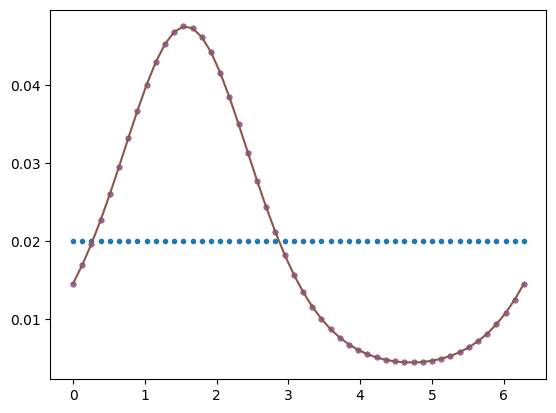

In [3]:
xs = np.linspace(0, 2*np.pi, 50)
Cs = np.sin(xs)

ps = np.ones(50) / 50

for i in range(5):
    plt.plot(xs, ps, '.')
    ps, LM = min_kl_cvxpy(ps, Cs, 0.5, direction='reverse', return_lagrange=True)

    if i == 0:
        lagrange = LM

gt = np.exp(-lagrange[1]*Cs)
gt = gt / gt.sum()
plt.plot(xs, gt)

Excellent: this works exactly as we would expect. In this case, the problem is equivalent to entropy minimization, so it should work like this for reasons besides my own solutions.

### Forward KL

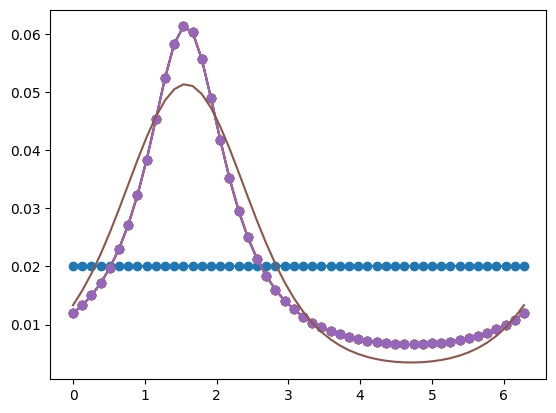

In [4]:
xs = np.linspace(0, 2*np.pi, 50)
Cs = np.sin(xs)

ps = np.ones(50) / 50

for i in range(5):
    plt.plot(xs, ps, '-o')
    ps, LM = min_kl_cvxpy(ps, Cs, 0.5, direction='forward', return_lagrange=True)

    if i == 0:
        lagrange = LM

gt = np.exp(-lagrange[1]*Cs)
gt = gt / gt.sum()
plt.plot(xs, gt)

This one looks different. It again converges after only one iteration, but the resulting distribution is not the same as the theoretical result.

What's more, it seems that the outputs _should_ alway converge after exactly one step: any output that satisfies the constraints will be as close to itself as possible, under any $f$ divergence.

I must be missing something important about my previous solutions...

#### I think I've figured it out

The missing factor is the change of variables between $s$ and $\theta$. This $f$-divergence minimization gives the distribution in units of $s$, but we really want the distribution in terms of $\theta$. Moreover, the constraint is a function of $\theta$, so the change of variables should also take that into account.

I don't think this works a a short-cut to our previous results.

## Pulling out the old solutions

In [2]:
%run old_solutions_analytic.py

from scipy.stats import uniform

Starting with simple examples

### general investigation

In [3]:
p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)


sol = findSol(p, L_deriv_inv, (C, dC), 0.1)

In [4]:
sol

       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  1.672e-03 ...  9.983e-01  1.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x125a03540>
             p: [ 2.831e+00]
             y: [[ 0.000e+00  1.069e-03 ...  9.989e-01  1.000e+00]
                 [-1.566e+00 -1.561e+00 ... -1.561e+00 -1.566e+00]
                 [-2.068e-22  4.172e-04 ...  9.958e-02  1.000e-01]]
            yp: [[ 6.385e-01  6.404e-01 ...  6.404e-01  6.385e-01]
                 [ 2.831e+00  2.825e+00 ... -2.825e+00 -2.831e+00]
                 [ 2.500e-01  2.489e-01 ...  2.489e-01  2.500e-01]]
 rms_residuals: [ 2.321e-06  2.325e-06 ...  1.036e-08  3.832e-09]
         niter: 2

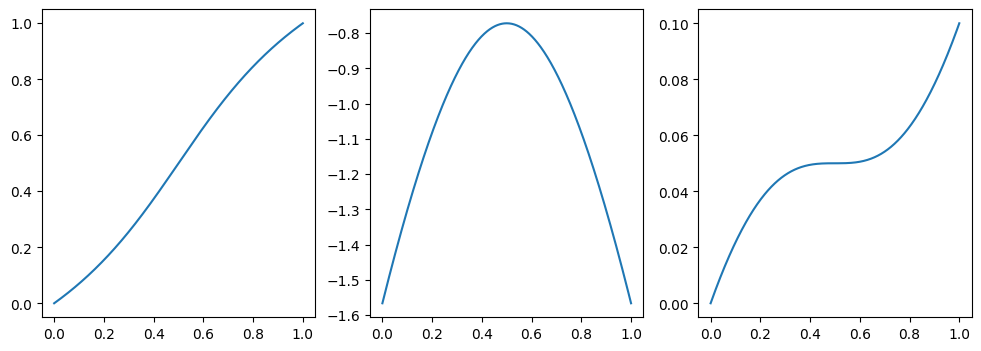

In [5]:
figsize(12,4)
plt.subplots(1,3)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(sol.x, sol.y[i,:])

Ok, what am I plotting here?

1. location on the coding manifold
2. 'momentum' costate
3. total accumulated constraint value

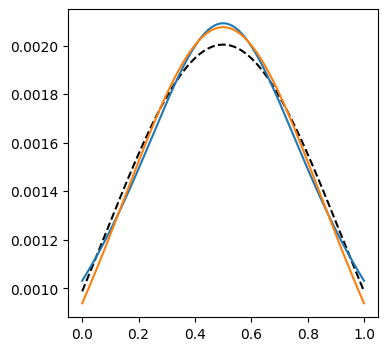

In [6]:
figsize(4,4)

p_gt =  np.exp(-sol.p[0] * C(sol.x)) 
plt.plot(sol.x, p_gt / p_gt.sum(), '--k')
plt.plot(sol.x, sol.yp[0,:] / sol.yp[0,:].sum())
plt.plot(sol.x, np.exp(sol.y[1,:]) / np.exp(sol.y[1,:]).sum() )

These things are similar, but not the same. Unfortunately, the solutions that we found don't really match the ground truth.

Moreover, shouldn't the derivative be in the denominator?

Yes, but this is a function of $s$, not of $\theta$

In [7]:
s = sol.x
theta = sol.y[0,:]

midpoints = (theta[:-1] + theta[1:])/2

s_cdf = p.cdf(s)

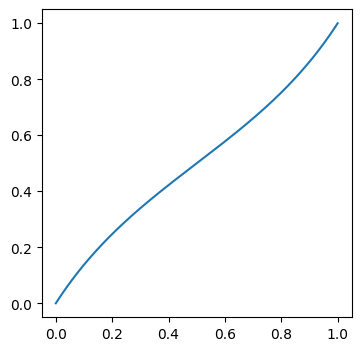

In [8]:
plt.plot(theta, s_cdf)

In [9]:
from scipy.interpolate import CubicSpline

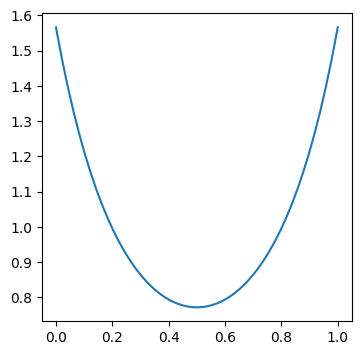

In [10]:
spline = CubicSpline(theta, s_cdf)

thetas = np.linspace(0,1)
plt.plot(thetas, spline.derivative()(thetas))

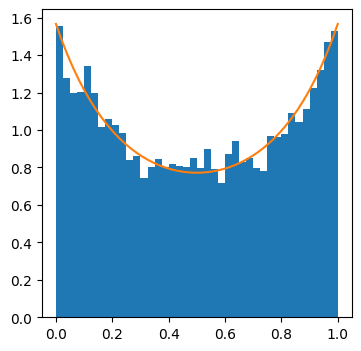

In [11]:
def get_theta(s): return sol.sol(s)[0]

s_samp = p.rvs(10000)
plt.hist( get_theta(s_samp), density=True, bins=40)
plt.plot(thetas, spline.derivative()(thetas))

Ok, that's not right. This solution is concentrated where the constraint is large... Am I off by a sign?

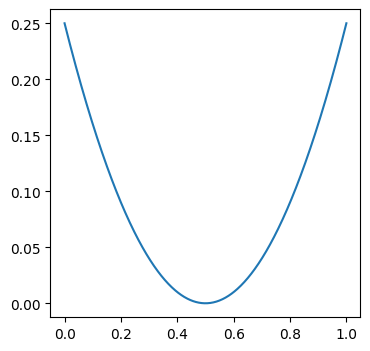

In [12]:
figsize(4,4)
plt.plot(theta, C(theta))

#### Ans:

No. We're not off by a sign. The problem is that this solution assumes that the constraint is _binding_, so solutions might bend toward highly constrained areas if the constraint value is too large.

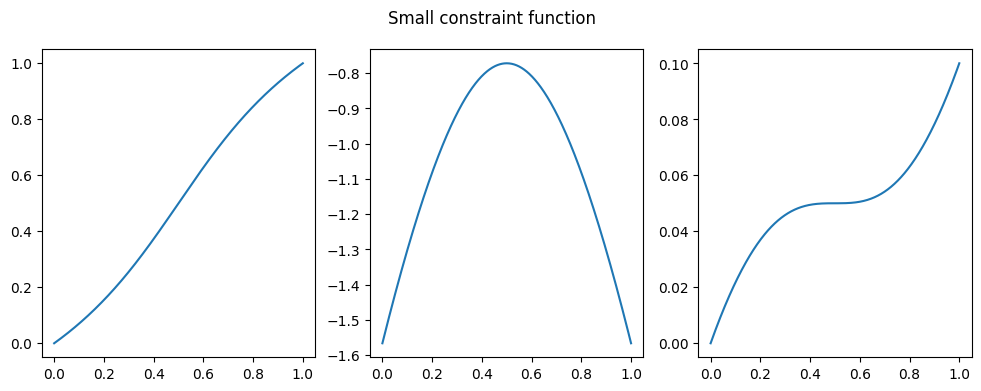

In [13]:
figsize(12,4)
plt.subplots(1,3)
plt.suptitle('Small constraint function')

p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = findSol(p, L_deriv_inv, (C, dC), 0.1)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(sol.x, sol.y[i,:])

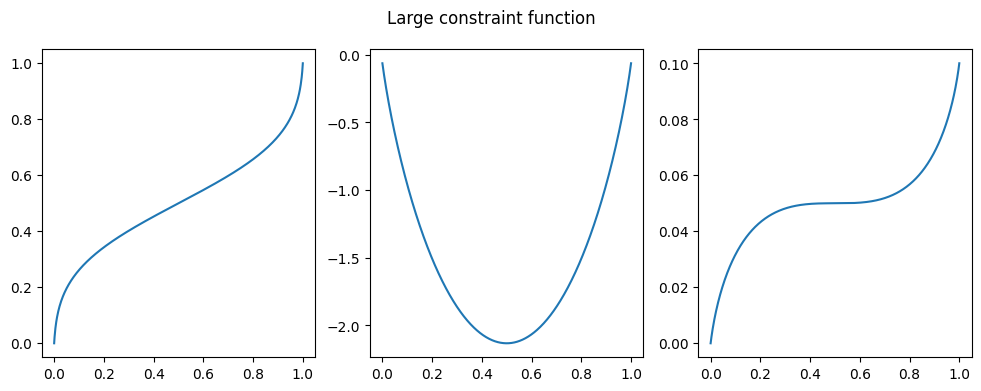

In [14]:
figsize(12,4)
plt.subplots(1,3)
plt.suptitle('Large constraint function')

p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: 3*(x-0.5)**2
dC = lambda x: 3*2*(x-0.5)

sol = findSol(p, L_deriv_inv, (C, dC), 0.1)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(sol.x, sol.y[i,:])

/Users/luke/Documents/NNtraining/angleFineTuning/old_solutions_analytic.py:125: UserWarning: Slack Constraint
  warn('Slack Constraint')


slack 0.08333329899468346


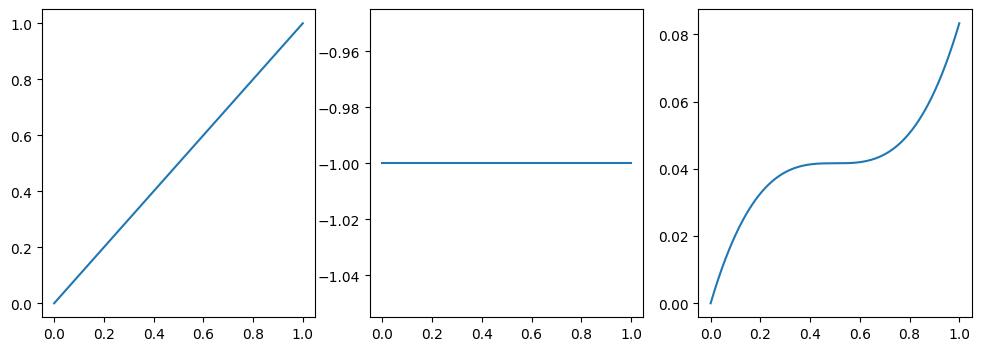

In [15]:
figsize(12,4)
plt.subplots(1,3)

p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.1)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(sol.x, sol.y[i,:])

Ok nice. This was all already taken care of.

0.05 0.08333329899468346


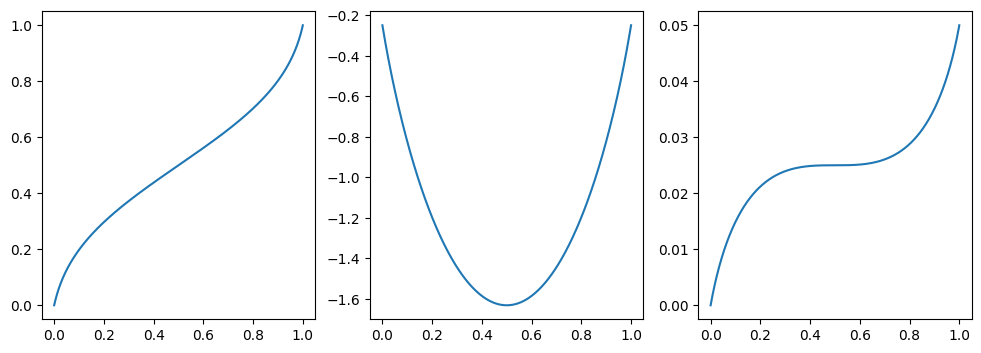

In [16]:
figsize(12,4)
plt.subplots(1,3)

p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.05)

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(sol.x, sol.y[i,:])

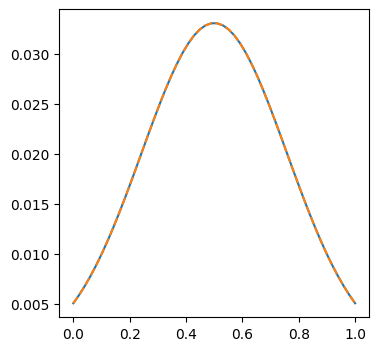

In [17]:
s = sol.x
theta = sol.y[0,:]

midpoints = (theta[:-1] + theta[1:])/2

s_cdf = p.cdf(s)

from scipy.interpolate import CubicSpline

spline = CubicSpline(theta, s_cdf)

thetas = np.linspace(0,1)
figsize(4,4)
plt.plot(thetas, spline.derivative()(thetas) / spline.derivative()(thetas).sum() )
plt.plot(thetas, np.exp(sol.p*C(thetas)) / np.exp(sol.p*C(thetas)).sum(), '--')

Perfect.

### adding in iteration

In [18]:
from scipy.interpolate import CubicSpline
from scipy.stats import rv_continuous

def output_dist(sol, p):
    """ solve for the distribution of outputs """
    s = sol.x
    theta = sol.y[0,:]
    s_cdf = p.cdf(s)
    
    theta_cdf = CubicSpline(theta, s_cdf)
    theta_pdf = theta_cdf.derivative()

    class output_rv(rv_continuous):
        def __init__(self):
            super().__init__(a=0, b=1)
        def _cdf(self, x):
            return theta_cdf(x)
        def _pdf(self, x):
            return theta_pdf(x)

    return output_rv()


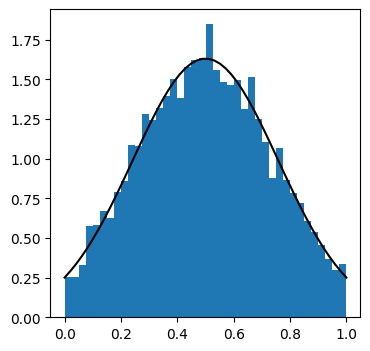

In [19]:
dist = output_dist(sol, p)

rvs = dist.rvs(size=5000)

thetas = np.linspace(0,1)
figsize(4,4)
plt.plot(thetas, dist.pdf(thetas), 'k')
plt.hist(rvs, bins=40, density=True);

Alright, that looks pretty good.

In [20]:
p = uniform()
loss = lambda x: np.log(x)

L_deriv_inv = lambda x: 1./x
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.05)
dist = output_dist(sol, p)

sol2 = ratchetConstraint(dist, L_deriv_inv, (C, dC), 0.05)
dist2 = output_dist(sol2, dist)

0.05 0.08333329899468346
0.05 0.08333330020219892


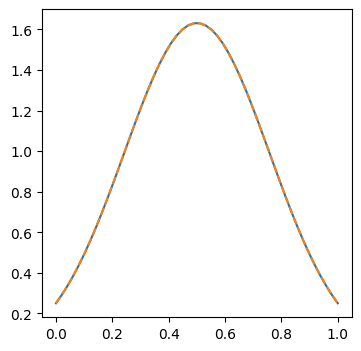

In [21]:
thetas = np.linspace(0, 1)

plt.plot(thetas, dist.pdf(thetas))
plt.plot(thetas, dist2.pdf(thetas), '--')

Nice. Everything is in place now.

### Different loss functions

Note that there can be difficulties with the solution whenever the inverse loss function derivative (L_deriv_inv) requires positive inputs, as this is not guaranteed by the ODE solver. The way that I'm solving this right now is by fiddling with the initial conditions: not the best approach, but it seems to work resonably well.


__Idea for improvement:__
Use results from optimization with log-objective function as a 

#### Square root loss

In [234]:
%run old_solutions_analytic.py
from scipy.stats import uniform

p = uniform()
loss = lambda x: np.sqrt(x)

L_deriv_inv = lambda x: 1./(4*x**2)
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

def run_iter(p):
    sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.05)
    dist = output_dist(sol, p)

    return dist

<Figure size 400x400 with 0 Axes>

0.05 0.08333370670641535


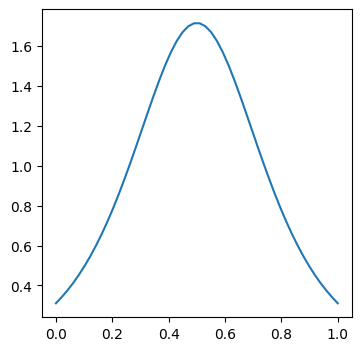

In [235]:
sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.05)
dist = output_dist(sol, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, dist.pdf(thetas))

0.05 0.08333370670641535
0.05 0.1125122112843785
0.05 0.10798495547321163
0.05 0.11175198475334236
0.05 0.108656349447998
0.079328174723999 0.108656349447998
0.05 0.079328174723999
0.05 0.11121814870591615
0.08060907435295808 0.11121814870591615
0.05 0.08060907435295808
0.05 0.1091094044882899
0.07955470224414496 0.1091094044882899
0.05 0.07955470224414496
0.05 0.11086500869662294
0.08043250434831148 0.11086500869662294
0.05 0.08043250434831148


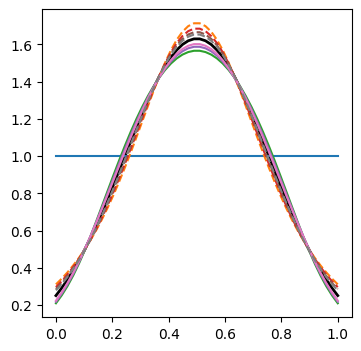

In [236]:
thetas = np.linspace(0, 1)
baseline = dist2

figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k', linewidth=2)

p = uniform()

for iter in range(8):
    style = '-'
    if iter % 2:
        style = '--'
    plt.plot(thetas, p.pdf(thetas), style)
    p = run_iter(p)


Interesting to note:
1. The solution is very close after only one iteration.
2. However, the convergence of a simple fixed point iteration is quite slow. In particular, the steps get closer to the limit, but they do oscillate around it.

In [237]:
p = uniform()

iterations = []
for iter in range(8):
    iterations.append(p)
    p = run_iter(p)

0.05 0.08333370670641535
0.05 0.1125122112843785
0.05 0.10798495547321163
0.05 0.11175198475334236
0.05 0.108656349447998
0.079328174723999 0.108656349447998
0.05 0.079328174723999
0.05 0.11121814870591615
0.08060907435295808 0.11121814870591615
0.05 0.08060907435295808
0.05 0.1091094044882899
0.07955470224414496 0.1091094044882899
0.05 0.07955470224414496
0.05 0.11086500869662294
0.08043250434831148 0.11086500869662294
0.05 0.08043250434831148


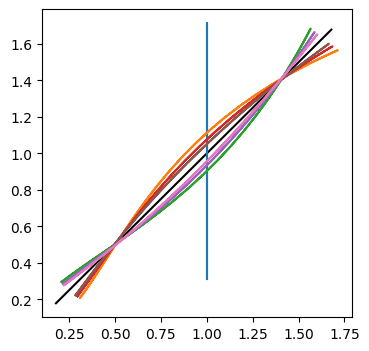

In [238]:
thetas = np.linspace(0, 1)

plt.plot(1.75*thetas[5:48], 1.75*thetas[5:48], 'k')
for i in range(len(iterations)-1):
    pin = iterations[i].pdf(thetas)
    pout = iterations[i+1].pdf(thetas)
    plt.plot(pin, pout)

This certainly looks like a poorly damped iteration, which could be massively improved by using a bisection method.

#### negative inverse x loss

0.06 0.08333333374269312
0.06 0.08333329899468346


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/1244994192.py:7: RuntimeWarning: invalid value encountered in sqrt
  L_deriv_inv = lambda x: 1./x**0.5


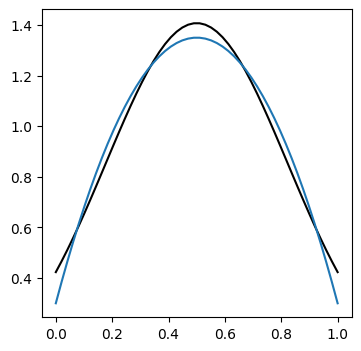

In [94]:
from scipy.stats import uniform


p = uniform()
loss = lambda x: -1. / x

L_deriv_inv = lambda x: 1./x**0.5
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
dist = output_dist(sol, p)

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

In [95]:
def run_iter(p):
    sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
    dist = output_dist(sol, p)

    return dist

0.06 0.08333333374269312
0.06 0.0721415831355851


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/1244994192.py:7: RuntimeWarning: invalid value encountered in sqrt
  L_deriv_inv = lambda x: 1./x**0.5


0.06 0.0719359425023105
0.06 0.07184501590935086


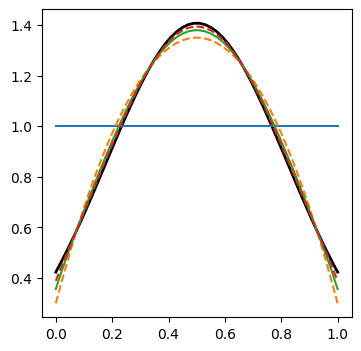

In [96]:
plt.plot(thetas, baseline.pdf(thetas), 'k', linewidth=2)

p = uniform()
iterations = []

for iter in range(4):
    iterations.append(p)
    style = '-'
    if iter % 2:
        style = '--'
    plt.plot(thetas, p.pdf(thetas), style)
    p = run_iter(p)

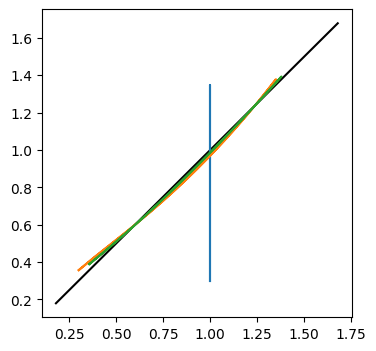

In [97]:
thetas = np.linspace(0, 1)

plt.plot(1.75*thetas[5:48], 1.75*thetas[5:48], 'k')
for i in range(len(iterations)-1):
    pin = iterations[i].pdf(thetas)
    pout = iterations[i+1].pdf(thetas)
    plt.plot(pin, pout)

#### $x^a$ with $1/2 < a < 1$

In [117]:
%run old_solutions_analytic.py

<Figure size 400x400 with 0 Axes>

0.06 0.08333335358886915
0.06 0.08333329899468346


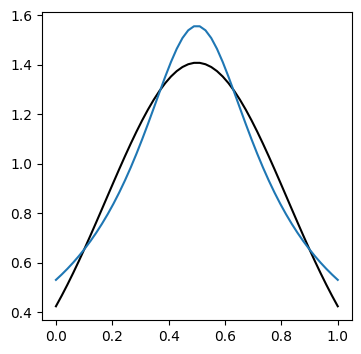

In [128]:
from scipy.stats import uniform


p = uniform()

a = 3./4.
loss = lambda x: x**a
L_deriv_inv = lambda x: (x / a)**(1./a)
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
dist = output_dist(sol, p)

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

0.06 0.08333335358886915
slack 0.03633991776301859
slack 0.014222376213363808
slack 0.005588533234061287


(0.0, 5.0)

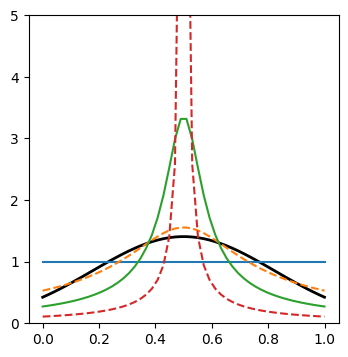

In [120]:
def run_iter(p, prev_sol=None):
    if prev_sol:
        def init(p, M, binding, domTheta):
            return prev_sol.x, prev_sol.y, prev_sol.p
        sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06, getInitial=init)
    else:
        sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
    dist = output_dist(sol, p)

    return dist, sol

plt.plot(thetas, baseline.pdf(thetas), 'k', linewidth=2)

p = uniform()
sol = None

iterations = []
for iter in range(4):
    iterations.append(p)
    style = '-'
    if iter % 2:
        style = '--'
    plt.plot(thetas, p.pdf(thetas), style)
    p, sol = run_iter(p, prev_sol=sol)

plt.ylim([0, 5])

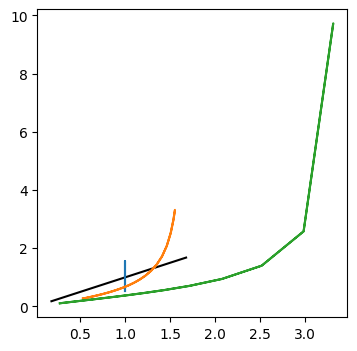

In [121]:
thetas = np.linspace(0, 1)

plt.plot(1.75*thetas[5:48], 1.75*thetas[5:48], 'k')
for i in range(len(iterations)-1):
    pin = iterations[i].pdf(thetas)
    pout = iterations[i+1].pdf(thetas)
    plt.plot(pin, pout)

The result is clear: the simple fixed point iteration fails to converge, similar to my derivations from several years ago. Also worth noting: the constraint becomes slack as the input distribution is more concentrated around the constraint minimum. That's an interesting behavior.

What happens in this case if we use the known fixed point as the input distribution?

0.06 0.0833333000070772
slack 0.032291801359312935


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/3869009208.py:8: RuntimeWarning: invalid value encountered in power
  L_deriv_inv = lambda x: (x / a)**(1./a)
/Users/luke/Documents/NNtraining/angleFineTuning/old_solutions_analytic.py:124: UserWarning: Slack Constraint
  warn('Slack Constraint')


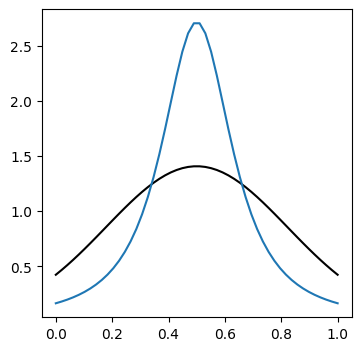

In [141]:
baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

p = baseline

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
dist = output_dist(sol, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

Indeed, the fixed-point itself appears unstable.

Part of this could be due to the loss on a binding constraint

0.06 0.16667371458621505
0.11333685729310752 0.16667371458621505
0.06 0.11333685729310752
0.08666842864655376 0.11333685729310752
0.06 0.08666842864655376
slack 0.002412172669480215


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/3869009208.py:8: RuntimeWarning: invalid value encountered in power
  L_deriv_inv = lambda x: (x / a)**(1./a)


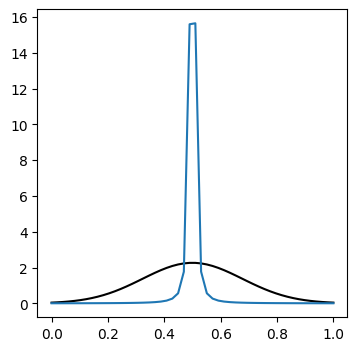

In [159]:
C = lambda x: 2*(x-0.5)**2
dC = lambda x: 2*2*(x-0.5)

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

p = baseline

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
dist = output_dist(sol, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

0.15 0.1533332990180739
0.14 0.1455996292688021


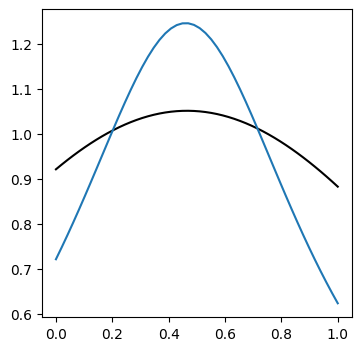

In [226]:
C = lambda x: (x-0.5)**2+0.07
dC = lambda x: 2*(x-0.5)+0.07

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.15)
baseline = output_dist(baseline, p)

p = baseline

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.14)
dist = output_dist(sol, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

0.14 0.15333329896156625
slack 0.1237290249157643


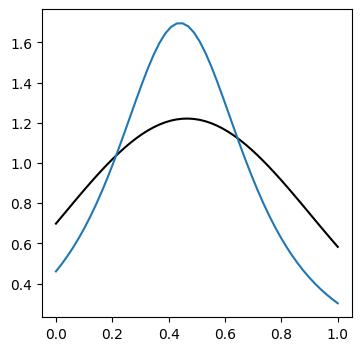

In [222]:
C = lambda x: (x-0.5)**2+0.07
dC = lambda x: 2*(x-0.5)+0.07

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.14)
baseline = output_dist(baseline, p)

p = baseline

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.14)
dist = output_dist(sol, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

Interestingly, I can't seem to find any conditions under which the constraint is binding for both the baseline and the solution that uses the baseline as an input distribution. See the previous two plots: the second solution is slack when the constraint value is the same, even though this is not the case when the constraint value is slightly larger. 

Perhaps this can elucidate the behavior of these solutions near the fixed point: they appear to converge to a delta function at the smallest value of the constraint. This is what you would expect if successive interations get more and more concentrated, while constrained to remain somewhat close to their input.

A question for a different day.

#### Summary

Ok, we now have examples of different convergence behaviors:
- alternating around the true distribution
- approaching it from below.
- diverging toward a delta function at the smallest constraint value

For the moment, lets focus on the convergent cases. It is not sufficient to simply average the two distributions or something: we need a better iterative approach. For example, the bisection approach.

Looking into the literature, there is a significant issue with naively applying the bisection approach on the probability simplex: it is intractable to compute the midpoint of a polygon in high dimensions: the complexity scales exponentially with the dimension.

### Linear interpolation

#### Revisiting the square-root loss function

The fact that this one was oscillatory means that output probabilities are _not_ pointwise monotonic in the input probabilities.

In [396]:
loss = lambda x: np.sqrt(x)

L_deriv_inv = lambda x: 1./(4*x**2)
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

def run_iter(p):
    sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.05)
    dist = output_dist(sol, p)

    return dist

p = uniform()
iterations = []
for iter in range(8):
    iterations.append(p)
    p = run_iter(p)

0.05 0.08333370670641535
0.05 0.1125122112843785
0.05 0.10798495547321163
0.05 0.11175198475334236
0.05 0.108656349447998
0.079328174723999 0.108656349447998
0.05 0.079328174723999
0.05 0.11121814870591615
0.08060907435295808 0.11121814870591615
0.05 0.08060907435295808
0.05 0.1091094044882899
0.07955470224414496 0.1091094044882899
0.05 0.07955470224414496
0.05 0.11086500869662294
0.08043250434831148 0.11086500869662294
0.05 0.08043250434831148


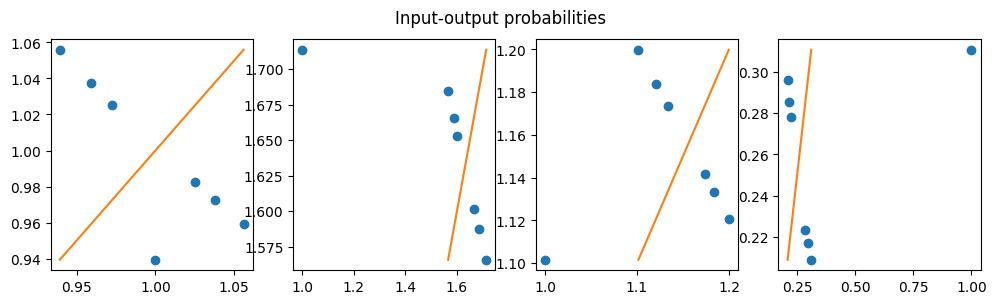

In [397]:
figsize(12, 3)
plt.subplots(1, 4)
plt.suptitle('Input-output probabilities')

thetas = np.linspace(0, 1)

ind=25

plt_ind = 1
for ind in [12, 25, 35, 49]:
    xs = []
    ys = []
    for i in range(len(iterations)-1):
        xs.append(iterations[i].pdf(thetas[ind]))
        ys.append(iterations[i+1].pdf(thetas[ind]))

    plt.subplot(1,4, plt_ind)
    plt.plot(xs, ys, 'o')
    min_p = np.min(xs[1:])
    max_p = np.max(xs[1:])
    l = np.linspace(min_p, max_p)
    plt.plot(l,l)
    plt_ind += 1

Ok. That seems about right. There is no clear property shared by all of the plots.

In [398]:
loss = lambda x: np.sqrt(x)

L_deriv_inv = lambda x: 1./x**0.5
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)
baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

def run_iter(p):
    sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
    dist = output_dist(sol, p)

    return dist

p = uniform()
iterations = []
for iter in range(8):
    iterations.append(p)
    p = run_iter(p)


0.06 0.0833332999301723
0.06 0.08333333374269312


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/4070272691.py:3: RuntimeWarning: invalid value encountered in sqrt
  L_deriv_inv = lambda x: 1./x**0.5


0.06 0.0721415831355851
0.06 0.0719359425023105
0.06 0.07184501590935086
0.06 0.07180302020202989
0.06 0.07178311665663044
0.06 0.07177356555689965
0.06 0.07176894968560632


0.02040816326530612
0.24489795918367346
0.5102040816326531
0.7142857142857142


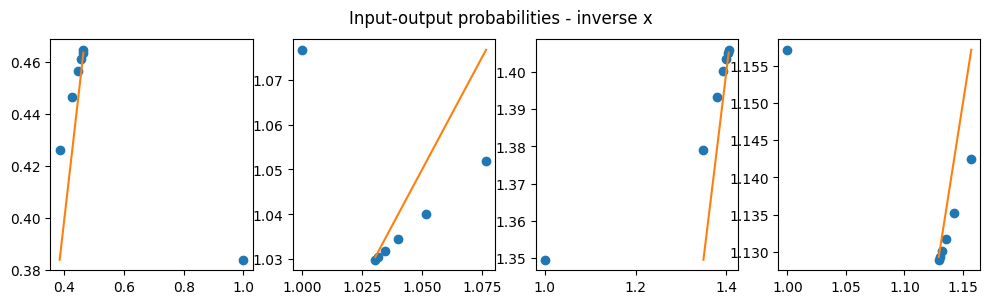

In [400]:
figsize(12, 3)
plt.subplots(1, 4)
plt.suptitle('Input-output probabilities - inverse x')

thetas = np.linspace(0, 1)

ind=25

plt_ind = 1
for ind in [1, 12, 25, 35]:
    print(thetas[ind])
    xs = []
    ys = []
    for i in range(len(iterations)-1):
        xs.append(iterations[i].pdf(thetas[ind]))
        ys.append(iterations[i+1].pdf(thetas[ind]))

    plt.subplot(1,4, plt_ind)
    plt.plot(xs, ys, 'o')
    min_p = np.min(xs[1:])
    max_p = np.max(xs[1:])
    l = np.linspace(min_p, max_p)
    plt.plot(l,l)
    plt_ind += 1

Also, it is neither increasing nor decreasing. Note that in both cases, however, the iterations after the first one do seem to have a common structure, and to describe a fairly linear function at that.

Essentially, the argument here is that, while the increasing/ decreasing behavior is not universal, it holds _close to_ the fixed point. Also interesting to note that (neglecting the first point), the points are consistent in whether the are increaseing or decreasing _within_ each loss function, but not _between_ loss functions.

Note also that the points within the iteration are pretty much colinear, which introduces a new way to determine the next points.

In [379]:
from sklearn.linear_model import LinearRegression

def forecast_intercept(probability_iters):
    """ Perform linear regression on output probabilities,
        solve for intercept
    """
    prob_in = np.asarray(probability_iters[1:-1])[:, None]
    prob_out = np.asarray(probability_iters[2:])
    
    regr = LinearRegression().fit(prob_in, prob_out)

    return -regr.intercept_ / (regr.coef_  -1)


def next_step_forecast(iterations, locations):
    """ Find the next step by predicting where each location
        crosses the diagonal
    """
    iter_probs = np.array([dist.pdf(locations) for dist in iterations])

    num_cols = iter_probs.shape[1]
    
    pointwise_optimal = np.zeros(num_cols)
    for col in range(num_cols):
        pointwise_optimal[col] = forecast_intercept(iter_probs[:, col]).item()
        
    
    return pointwise_optimal
    




In [380]:
next_step_forecast(iterations, np.linspace(0, 1, 10))

array([0.42481007, 0.68029679, 0.97133224, 1.23129597, 1.38667531,
       1.38667402, 1.23129018, 0.97132633, 0.6802886 , 0.4248023 ])

In [383]:
np.trapz(next_step_forecast(iterations, np.linspace(0, 1, 10)), np.linspace(0,1,10))

0.9959984031848734

## How to hande noise in the Fisher information measurements?

### Crossing points

The problem that I'm addressing here is that the previous work makes it look like I need multiple iterations in order to determine whether the output probabilities increase or decrease with input probability. This might not be the case if we can use a comparison between the results at multiple locations

0.06 0.08333333374269312


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/1244994192.py:7: RuntimeWarning: invalid value encountered in sqrt
  L_deriv_inv = lambda x: 1./x**0.5


0.06 0.08333329899468346


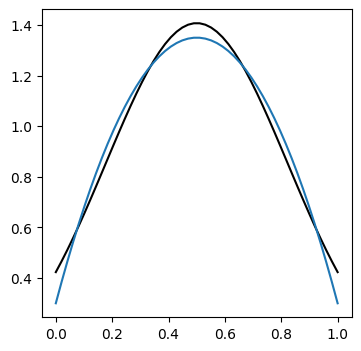

In [384]:
from scipy.stats import uniform


p = uniform()
loss = lambda x: -1. / x

L_deriv_inv = lambda x: 1./x**0.5
C = lambda x: (x-0.5)**2
dC = lambda x: 2*(x-0.5)

sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
dist = output_dist(sol, p)

baseline = ratchetConstraint(p,  lambda x: 1./x, (C, dC), 0.06)
baseline = output_dist(baseline, p)

thetas = np.linspace(0, 1)
figsize(4,4)
plt.plot(thetas, baseline.pdf(thetas), 'k')
plt.plot(thetas, dist.pdf(thetas))

0.06 0.08333333374269312


/var/folders/6v/zs8dzfhn6q13fwyd231yww400000gn/T/ipykernel_26239/1244994192.py:7: RuntimeWarning: invalid value encountered in sqrt
  L_deriv_inv = lambda x: 1./x**0.5


0.06 0.0721415831355851
0.06 0.0719359425023105
0.06 0.07184501590935086


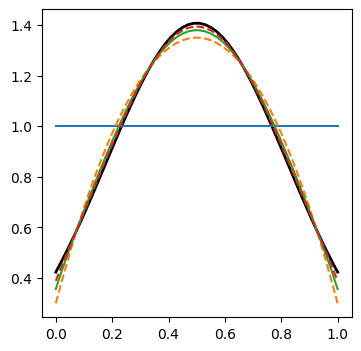

In [386]:
def run_iter(p):
    sol = ratchetConstraint(p, L_deriv_inv, (C, dC), 0.06)
    dist = output_dist(sol, p)

    return dist

plt.plot(thetas, baseline.pdf(thetas), 'k', linewidth=2)

p = uniform()
iterations = []

for iter in range(4):
    iterations.append(p)
    style = '-'
    if iter % 2:
        style = '--'
    plt.plot(thetas, p.pdf(thetas), style)
    p = run_iter(p)

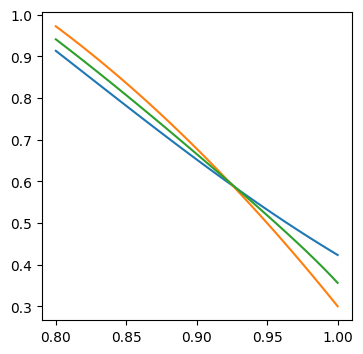

In [405]:
figsize(4,4)
thetas = np.linspace(0.8, 1.0)
plt.plot(thetas, baseline.pdf(thetas))
plt.plot(thetas, iterations[1].pdf(thetas))
plt.plot(thetas, iterations[2].pdf(thetas))

It seems like the point where output == input lies on the fixed-point distribution.

In this case, we know one point on the fixed-point distribution.

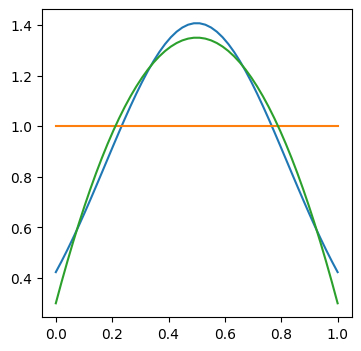

In [406]:
thetas = np.linspace(0., 1.0)
plt.plot(thetas, baseline.pdf(thetas))
plt.plot(thetas, iterations[0].pdf(thetas))
plt.plot(thetas, iterations[1].pdf(thetas))

That observation _does not_ apply when the input is uniform!

### I think I'm worrying too much about this without trying it out first

I need to try some examples with simple gp fits and linear interpolation 